In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import xgboost as xgb  
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics  
from sklearn.grid_search import GridSearchCV 

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
train_data = pd.read_csv('data/train_reviews_avgstars.csv')
test_data = pd.read_csv('data/test_reviews_avgstars.csv')
#train_data = pd.read_csv('data/TrainNum.csv') 
#test_data = pd.read_csv('data/TestNum.csv')

print(train_data.shape)
display(train_data.head(1))
# display(train_data.info())

print(test_data.shape)
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(150232, 7)


,userId,businessId,stars,userAverageStars,businessAverageStars,userReviewCounts,businessReviewCounts
0,VDh1vjzpNUJH6HfcjH8g7Q,WPCgtEG-bJt0cZtnM-x7yw,4.0,4.5,4.0,4,128


(50078, 7)


,userId,businessId,stars,userAverageStars,businessAverageStars,userReviewCounts,businessReviewCounts
0,XEDaNNCTVAqPpvyX2zY03g,e880MGw6C6PJL-n3EJoY_g,NaN,3.81,4.0,36,149


In [6]:
train_uid = train_data['userId']
train_bid = train_data['businessId']
train_Y = train_data['stars']
train_data.drop(['userId', 'businessId','stars'], axis=1, inplace=True)
train_X = train_data

test_uid = test_data['userId']
test_bid = test_data['businessId']
test_data.drop(['userId', 'businessId','stars'], axis=1, inplace=True)
test_X = test_data
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

In [7]:
from sklearn.metrics import mean_squared_error
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def fit_print_importance(xgb_regressor, trainX, trainY):
    xgbParam = xgb_regressor.get_xgb_params()
    cvresult = xgb.cv(xgbParam, dtrain, num_boost_round=xgbParam['n_estimators'], 
                              nfold=5, metrics='rmse', early_stopping_rounds=50)
    xgb_regressor.fit(trainX, trainY)
    predictions = xgb_regressor.predict(trainX)
    rmseScore = rmse(trainY, predictions)
    print("RMSE: ", rmseScore)
    
    feature = pd.Series(xgb_regressor.feature_importances_, trainX.columns.values)
    feature = feature.sort_values(ascending=False).head(40)
    feature.plot(kind='bar', title='Feature Importance')
    plt.ylabel('Feature Importance Score')
    
    return xgb_regressor, feature

RMSE:  0.9998645626211524


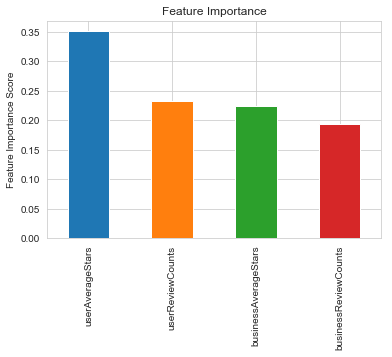

In [8]:
xgb_regressor = XGBRegressor(learning_rate =0.05, n_estimators = 300, max_depth=3, min_child_weight=1.1,
                             gamma=0.01, subsample=0.72, colsample_bytree=0.89, reg_lambda = 0.61, reg_alpha = 0.53,
                             scale_pos_weight=1, objective= 'reg:linear', seed=10)
xgb_regressor, feature = fit_print_importance(xgb_regressor,train_X, train_Y)   

In [9]:
predictions = xgb_regressor.predict(test_X)
aff = []
for i in predictions:
    if i < 1:
        i = 1
    if i > 5:
        i = 5
    aff.append(i) 
submission = pd.DataFrame({'stars': aff})
submission.index.name = "index"

submission.to_csv("results/boost.csv")